In [1]:
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
from glob import glob
import os
from matplotlib.colors import ListedColormap, BoundaryNorm
from utils import draw_legend
from config import Config

In [2]:
import warnings
warnings.filterwarnings('ignore')
config = Config()
dir_separator = config.dir_sep

In [3]:
fire_id = "25993"

In [4]:
image_dir = f"E:/Projects/UCB/FiredPy/data/Fire_events/{fire_id}/Sentinel/"
file_address = glob(os.path.join(image_dir, '*.SAFE'))

In [5]:
files = []
granules = []
image_DIRs = []

for file in file_address:
    files.append(file.split(dir_separator)[-1])
    granule_address = glob(os.path.join(file, "GRANULE/*"))[0]
    granules.append(granule_address.split(dir_separator)[-1])
    image_address = glob(os.path.join(granule_address, "IMG_DATA/R20m/*.jp2"))[1]
    image_DIRs.append(image_address.split("02_20m")[0].split(dir_separator)[-1])

In [6]:
labels = ["pre_fire", "post_fire"]
nbr_raws = dict.fromkeys(labels, None)
nbr_brdfs = dict.fromkeys(labels, None)

In [7]:
fire_events = gpd.read_file("../data/Fire_events/selected_events.shp")

In [8]:
mask_geom = fire_events[fire_events['id']==fire_id]['geometry'].values

In [9]:
# Whether to maks images to the extent of fires or not
MASK_IMAGES = True

In [10]:
def get_path(is_nbar, granule, resolution):
    """
    Generates the directory path for the image bands based on the provided parameters.

    This function is used to obtain the correct path for image bands. The directory
    structure for BRDF-corrected image bands (saved in the NBAR subfolder) is different
    from raw image bands.

    Parameters:
    -----------
    is_nbar : bool
        A flag indicating whether the image is BRDF-corrected (NBAR) or not.
    granule : str
        The identifier of the granule or image scene.
    resolution : int
        The spatial resolution of the image bands, which can be 10, 20, or 60 meters.

    Returns:
    --------
    str
        The directory path for the image bands based on the provided parameters.

    Raises:
    -------
    ValueError
        If an invalid resolution is provided.
    """
    if is_nbar:
        rgb_path = "NBAR"
    else:
        if resolution == 10:
            rgb_path = f"GRANULE/{granule}/IMG_DATA/R10m"
        elif resolution == 20:
            rgb_path = f"GRANULE/{granule}/IMG_DATA/R20m"
        elif resolution == 60:
            rgb_path = f"GRANULE/{granule}/IMG_DATA/R60m"
        else:
            print("Wrong resolution inserted!")
    
    return rgb_path

In [11]:
def read_image(SAFE, granule, image_name, ext, is_nbar, shift_dn, is_sr):
    """
    Opens and loads Sentinel-2 images into memory.

    This function reads NIR and SWIR bands from Sentinel-2 images, resamples the SWIR band to
    match the resolution of the NIR band, and combines them into an xarray dataset. It also
    performs some preprocessing steps, such as clipping the images with a mask, applying a shift,
    and handling surface reflectance (SR) images.

    Parameters:
    -----------
    SAFE : str
        The path to the Sentinel-2 SAFE directory.
    granule : str
        The identifier of the granule or image scene.
    image_name : str
        The base name of the image.
    ext : str
        The file extension of the image (e.g., "jp2").
    is_nbar : bool
        A flag indicating whether the image is BRDF-corrected (NBAR) or not.
    shift_dn : bool
        A flag indicating whether to apply a shift to the pixel values.
    is_sr : bool
        A flag indicating whether the image is surface reflectance (SR) or not.

    Returns:
    --------
    xarray.Dataset
        An xarray dataset containing the NIR and SWIR bands of the image.

    Note:
    -----
    This function assumes that the images are stored in the SAFE directory with a specific
    naming convention and directory structure. It also assumes that the NIR band is stored
    at a 10m resolution and the SWIR band at a 20m resolution.
    """
    bands = []    
    
    if MASK_IMAGES:
        nir = rioxarray.open_rasterio(f"{SAFE}/{get_path(is_nbar,granule, 10)}/{image_name}08_10m.{ext}").rio.clip(mask_geom, fire_events.crs)
        swir = rioxarray.open_rasterio(f"{SAFE}/{get_path(is_nbar, granule, 20)}/{image_name}12_20m.{ext}").rio.clip(mask_geom, fire_events.crs)
    else:
        nir = rioxarray.open_rasterio(f"{SAFE}/{get_path(is_nbar,granule, 10)}/{image_name}08_10m.{ext}")
        swir = rioxarray.open_rasterio(f"{SAFE}/{get_path(is_nbar, granule, 20)}/{image_name}12_20m.{ext}")
    
    print("original NIR ", nir.shape)
    print("original SWIR ", swir.shape)
    
    if is_sr:
        nir = nir.where(lambda x: x > 0, other=np.nan)
        swir = swir.where(lambda x: x > 0, other=np.nan)
        
    bands.append(nir)

    swir_resampled = swir.rio.reproject_match(nir)
    bands.append(swir_resampled)
    print("resampled SWIR ", swir_resampled.shape)

    del nir, swir, swir_resampled
        
    
    image = xr.concat(bands, dim="band")
    image = image.assign_coords(dict(band=["nir", "swir"]))
    if shift_dn: #TODO: Lookup what this shift is for
        image = image - 1000
    
    image_type = "SR" if is_sr else "NBAR"
    print(f"image {image_type} loaded")

    return image

In [12]:
def open_RGB(SAFE, rgb_path, image_name, ext, shift_dn):
    """
    Loads the red, green, and blue bands of a Sentinel-2 image to create an RGB image.

    This function reads the red (B4), green (B3), and blue (B2) bands from a Sentinel-2 image,
    combines them into an xarray dataset, and applies a shift to the pixel values if specified.
    The function can also clip the images with a mask if the global variable MASK_IMAGES is set to True.

    Parameters:
    -----------
    SAFE : str
        The path to the Sentinel-2 SAFE directory.
    rgb_path : str
        The directory path where the red, green, and blue bands of the image are stored.
    image_name : str
        The base name of the image.
    ext : str
        The file extension of the image (e.g., "jp2").
    shift_dn : bool
        A flag indicating whether to apply a shift to the pixel values.

    Returns:
    --------
    xarray.Dataset
        An xarray dataset containing the red, green, and blue bands of the image.

    Note:
    -----
    This function assumes that the images are stored in the SAFE directory with a specific
    naming convention and directory structure. It also assumes that the red, green, and blue
    bands are stored at a 10m resolution.
    """
    if MASK_IMAGES:
        rgb = [rioxarray.open_rasterio(f"{SAFE}/{rgb_path}/{image_name}0{x}_10m.{ext}").rio.clip(mask_geom, fire_events.crs) for x in [4,3,2]]
    else:
        rgb = [rioxarray.open_rasterio(f"{SAFE}/{rgb_path}/{image_name}0{x}_10m.{ext}") for x in [4,3,2]]
    
    rgb = xr.concat(rgb, dim="band")
    rgb = rgb.assign_coords(dict(band=["r","g","b"]))
    if shift_dn:
        rgb = rgb - 1000
    return rgb

In [13]:
def false_color(SAFE, granule, image_name, ext, shift_dn):
    """
    Generates a false-color composite image using three bands of a Sentinel-2 image.

    This function reads the SWIR (B12), NIR (B8A), and red (B4) bands from a Sentinel-2 image,
    combines them into an xarray dataset, and applies a shift to the pixel values if specified.
    The function can also clip the images with a mask if the global variable MASK_IMAGES is set to True.

    Parameters:
    -----------
    SAFE : str
        The path to the Sentinel-2 SAFE directory.
    granule : str
        The identifier of the granule (specific part of the image) being used.
    image_name : str
        The base name of the image.
    ext : str
        The file extension of the image (e.g., "jp2").
    shift_dn : bool
        A flag indicating whether to apply a shift to the pixel values.

    Returns:
    --------
    xarray.Dataset
        An xarray dataset containing the SWIR, NIR, and red bands of the image.

    Note:
    -----
    This function assumes that the images are stored in the SAFE directory with a specific
    naming convention and directory structure. It also assumes that the SWIR and NIR bands
    are stored at a 20m resolution, while the red band is stored at a 10m resolution.
    """
    if MASK_IMAGES:
        rgb = [rioxarray.open_rasterio(f"{SAFE}/{get_path(False,granule,20)}/{image_name}{x}_20m.{ext}").rio.clip(mask_geom, fire_events.crs) for x in ["12","8A"]]
        b = rioxarray.open_rasterio(f"{SAFE}/{get_path(False,granule,10)}/{image_name}04_10m.{ext}").rio.clip(mask_geom, fire_events.crs)
    else:
        rgb = [rioxarray.open_rasterio(f"{SAFE}/{get_path(False,granule,20)}/{image_name}{x}_20m.{ext}") for x in ["12","8A"]]
        b = rioxarray.open_rasterio(f"{SAFE}/{get_path(False,granule,10)}/{image_name}04_10m.{ext}")
    
    b = b.rio.reproject_match(rgb[0])
    rgb.append(b)
    rgb = xr.concat(rgb, dim="band")
    rgb = rgb.assign_coords(dict(band=["swir","nir","r"]))
    if shift_dn:
        rgb = rgb - 1000
    del b
    return rgb

In [14]:
def get_NBRs(image_sr, image_nbar):
    """
    Calculates the Normalized Burn Ratio (NBR) for both Surface Reflectance (SR) and NBAR Sentinel-2 images.

    This function computes the NBR, which is used to identify burned areas in satellite images.
    The NBR is calculated using the Near-Infrared (NIR) and Short-Wave Infrared (SWIR) bands of the images.
    The formula for NBR is given by:
    
    NBR = (NIR - SWIR) / (NIR + SWIR)

    Parameters:
    -----------
    image_sr : xarray.Dataset
        An xarray dataset containing the SR image bands.
    image_nbar : xarray.Dataset
        An xarray dataset containing the NBAR image bands.

    Returns:
    --------
    tuple of xarray.DataArray
        A tuple containing the NBR calculated from the SR image and the NBR calculated from the NBAR image.

    Note:
    -----
    This function assumes that the input images contain the "nir" and "swir" bands.
    """

    # NBR = (B08 - B12) / (B08 + B12)
    NBR_SR = (image_sr.sel(band="nir") - image_sr.sel(band="swir"))/(image_sr.sel(band="nir") + image_sr.sel(band="swir"))
    NBR_NBAR = (image_nbar.sel(band="nir") - image_nbar.sel(band="swir"))/(image_nbar.sel(band="nir") + image_nbar.sel(band="swir"))
    
    return NBR_SR, NBR_NBAR

In [16]:
SR_images = []
Brdf_images = []
for file, granule, image_name, label in zip(files, granules, image_DIRs, labels):
    SAFE = image_dir + file
    
    image_sr = read_image(SAFE, granule, image_name, "jp2", False, False, True)
    image_nbar = read_image(SAFE, granule, image_name, "tif", True, False, False)
    SR_images.append(image_sr)
    Brdf_images.append(image_nbar)
    
    NBR_SR, NBR_NBAR = get_NBRs(image_sr, image_nbar)
    nbr_raws[label] = NBR_SR
    nbr_brdfs[label] = NBR_NBAR 

original NIR  (1, 10980, 10980)
original SWIR  (1, 5490, 5490)
resampled SWIR  (1, 10980, 10980)
image SR loaded
original NIR  (1, 10980, 10980)
original SWIR  (1, 5490, 5490)
resampled SWIR  (1, 10980, 10980)
image NBAR loaded
original NIR  (1, 10980, 10980)
original SWIR  (1, 5490, 5490)
resampled SWIR  (1, 10980, 10980)
image SR loaded
original NIR  (1, 10980, 10980)
original SWIR  (1, 5490, 5490)
resampled SWIR  (1, 10980, 10980)
image NBAR loaded


In [17]:
pct_gt_1_pre = len(np.where(nbr_raws["pre_fire"]>1)[1])/(nbr_raws["pre_fire"].shape[0]*nbr_raws["pre_fire"].shape[1])*100
pct_gt_1_post = len(np.where(nbr_raws["post_fire"]>1)[1])/(nbr_raws["post_fire"].shape[0]*nbr_raws["post_fire"].shape[1])*100

print(f"{pct_gt_1_pre:0.2f} percent of the NBR values in the pre-fire image are greater than 1.")
print(f"{pct_gt_1_post:0.2f} percent of the NBR values in the post-fire image are greater than 1.")

0.00 percent of the NBR values in the pre-fire image are greater than 1.
0.00 percent of the NBR values in the post-fire image are greater than 1.


In [17]:
dNBR_post_raw = nbr_raws["pre_fire"] - nbr_raws["post_fire"]

In [18]:
dNBR_post_BRDF = nbr_brdfs["pre_fire"] - nbr_brdfs["post_fire"]

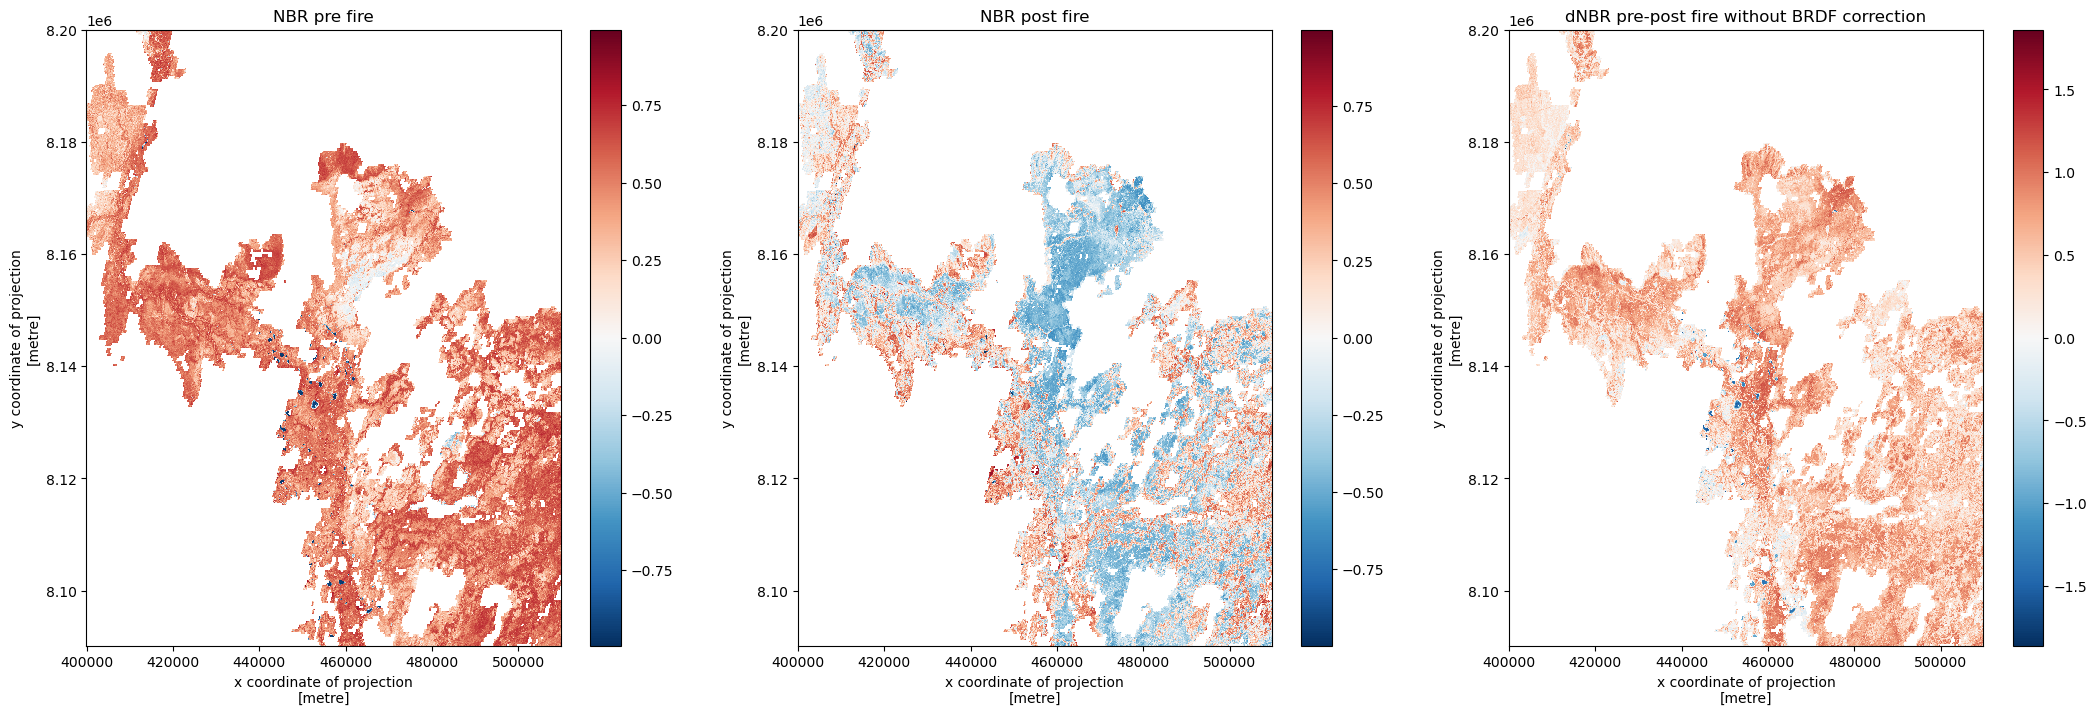

In [19]:
fig, axes = plt.subplots(1,3,figsize=(26,8)) #

nbr_raws["pre_fire"].plot.imshow(ax=axes[0])
axes[0].set_title("NBR pre fire")



nbr_raws["post_fire"].plot.imshow(ax=axes[1])
axes[1].set_title("NBR post fire")


dNBR_post_raw.plot.imshow(ax=axes[2])
axes[2].set_title("dNBR pre-post fire without BRDF correction")


fig.savefig(f'images/masked/dNBR_event_{fire_id}.png', dpi=300)

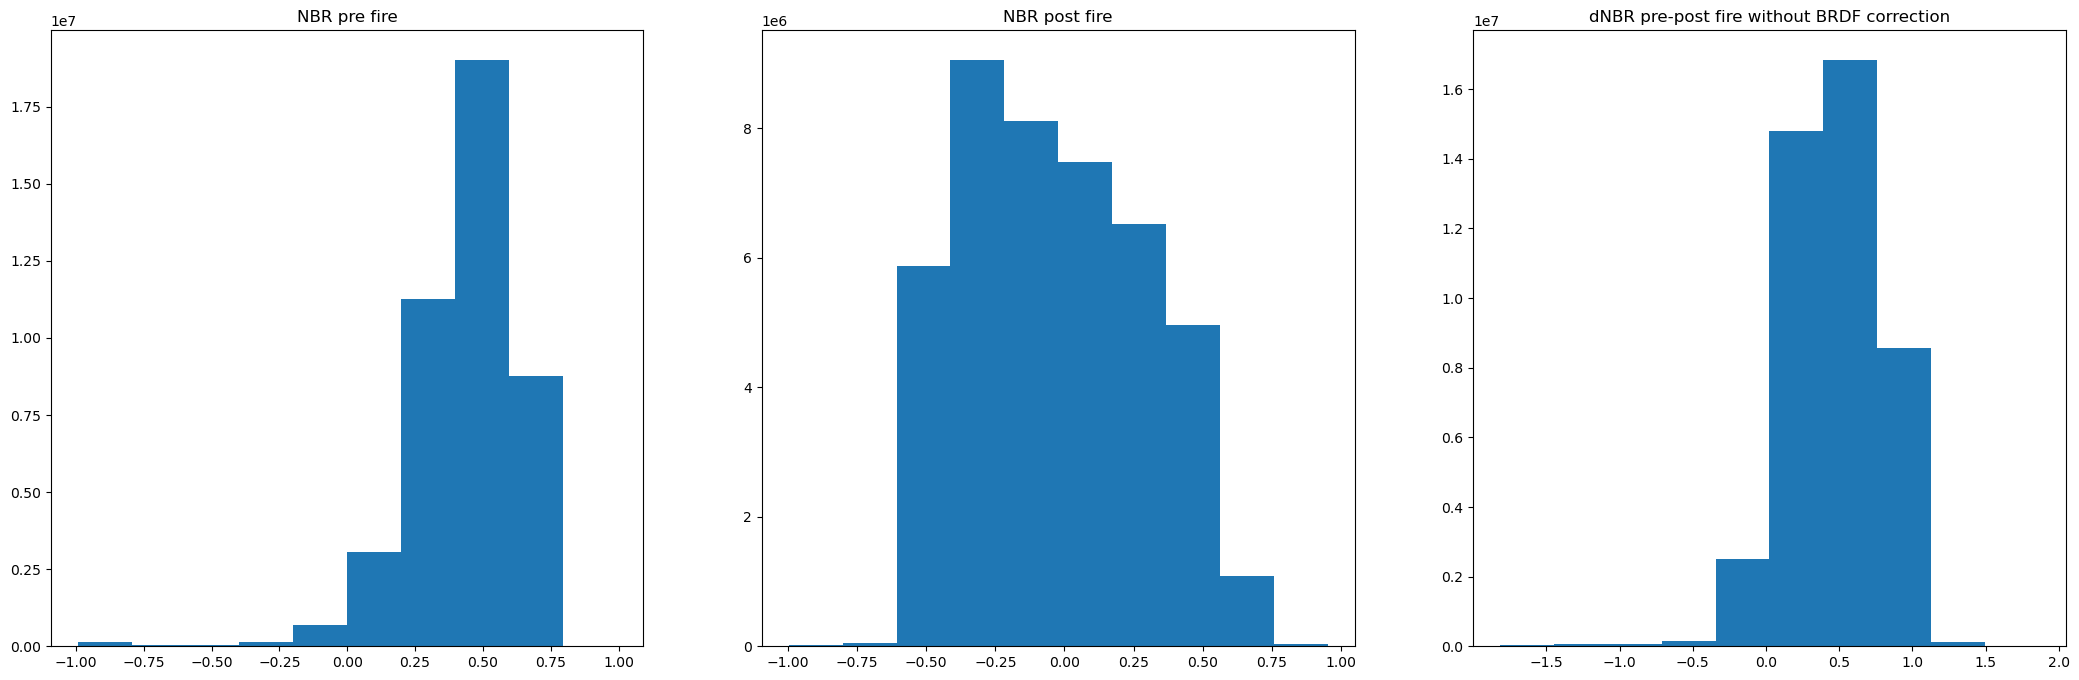

In [20]:
fig, axes = plt.subplots(1,3,figsize=(26,8)) #

axes[0].hist(nbr_raws["pre_fire"].values.ravel())
axes[0].set_title("NBR pre fire")

axes[1].hist(nbr_raws["post_fire"].values.ravel())
axes[1].set_title("NBR post fire")

axes[2].hist(dNBR_post_raw.values.ravel())
axes[2].set_title("dNBR pre-post fire without BRDF correction")


fig.savefig(f'images/masked/NBR_histogram_event_{fire_id}.png', dpi=300)

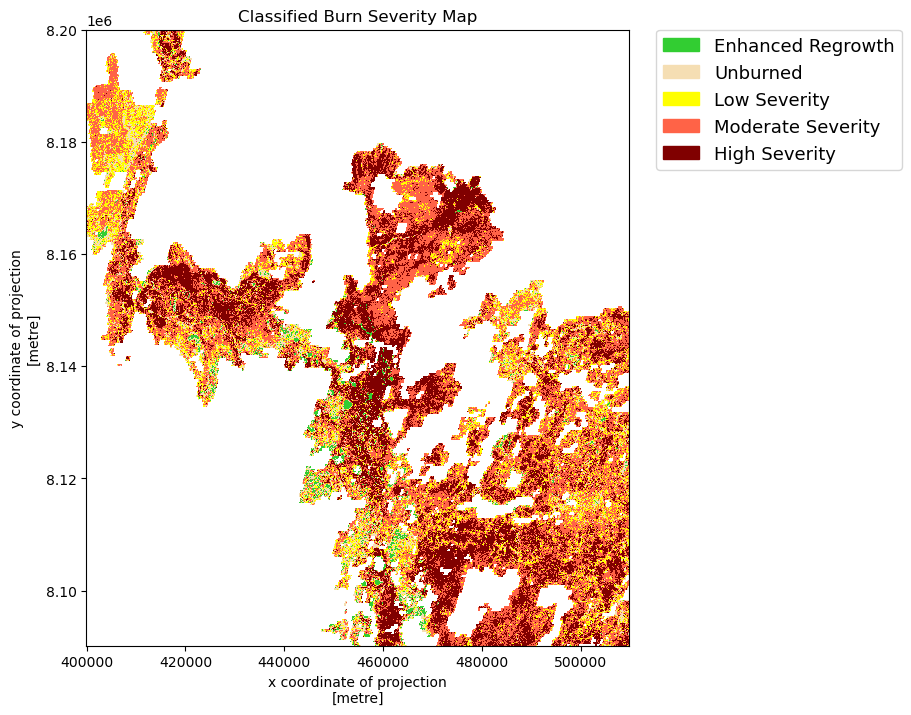

In [21]:
# Severity definitions taken from https://www.earthdatascience.org/courses/earth-analytics/multispectral-remote-sensing-modis/normalized-burn-index-dNBR/

severity_bins = [np.nanmin(dNBR_post_raw.values), -0.1, 0.1, 0.27, 0.66, np.nanmax(dNBR_post_raw.values)]

dNBR_post_raw_class = xr.apply_ufunc(np.digitize,
                                     dNBR_post_raw,
                                     severity_bins)

# Mask out values not equalt to 6 which represents Nan values
dNBR_post_raw_class_ma = dNBR_post_raw_class.where(dNBR_post_raw_class != 6)


# Plot data using nicer colors
colors = ['limegreen', 'wheat', 'yellow', 'tomato', 'maroon']
severity_labels = ["Enhanced Regrowth",
                   "Unburned",
                   "Low Severity",
                   "Moderate Severity",
                   "High Severity"]

class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5]

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))


fig, ax = plt.subplots(figsize=(7, 8))
plot = dNBR_post_raw_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
draw_legend(plot,titles=severity_labels)
ax.set(title="Classified Burn Severity Map")

fig.savefig(f'images/masked/classified_dNBR_event_{fire_id}.png', dpi=300, bbox_inches='tight')

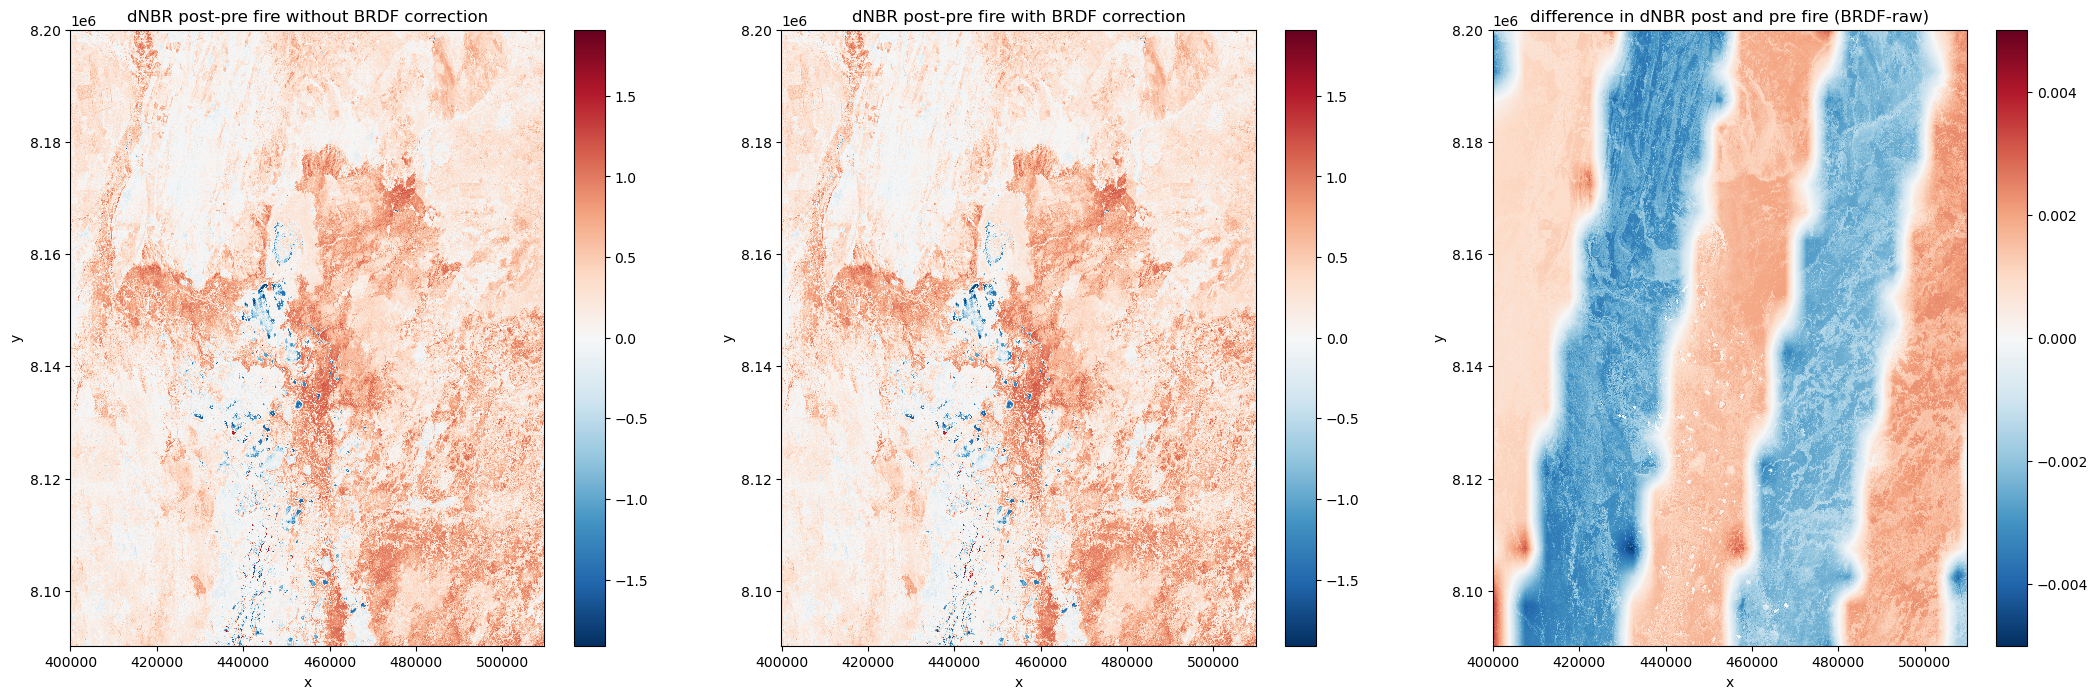

In [19]:
fig, axes = plt.subplots(1,3,figsize=(26,8)) #



dNBR_post_raw.plot.imshow(ax=axes[0])
axes[0].set_title("dNBR post-pre fire without BRDF correction")


dNBR_post_BRDF.plot.imshow(ax=axes[1])
axes[1].set_title("dNBR post-pre fire with BRDF correction")


(dNBR_post_BRDF - dNBR_post_raw).plot.imshow(ax=axes[2])
axes[2].set_title("difference in dNBR post and pre fire (BRDF-raw)")


fig.savefig(f'images/dNBR variation_event_{fire_id}.png', dpi=300)

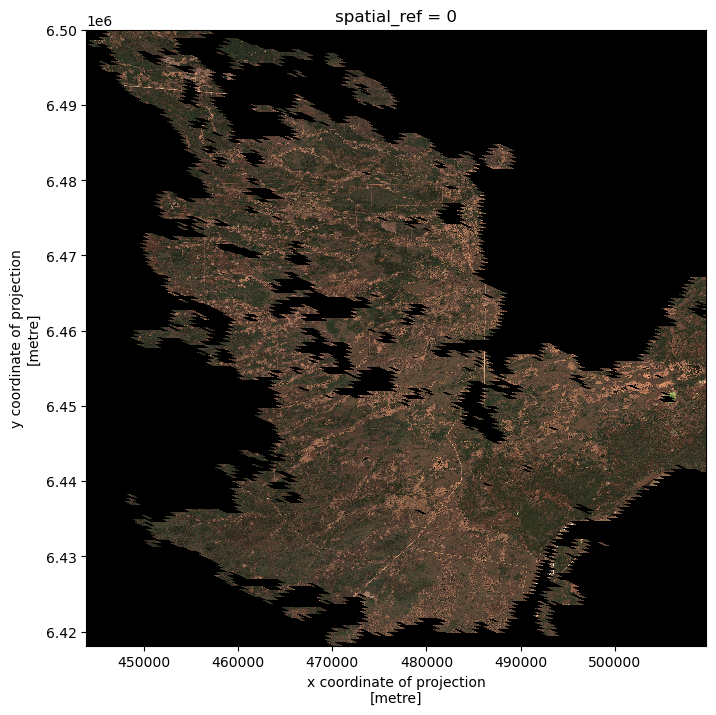

In [19]:
image_rgb = open_RGB(image_dir + files[0], f"GRANULE/{granules[0]}/IMG_DATA/R10m", image_DIRs[0], "jp2", False)

fig, axes = plt.subplots(figsize=(8,8))
(image_rgb/2000).clip(0,1).plot.imshow(ax=axes)
fig.savefig(f'images/masked/RGB_event_{fire_id}_pre_{files[0].split("_")[2]}.png', dpi=300)

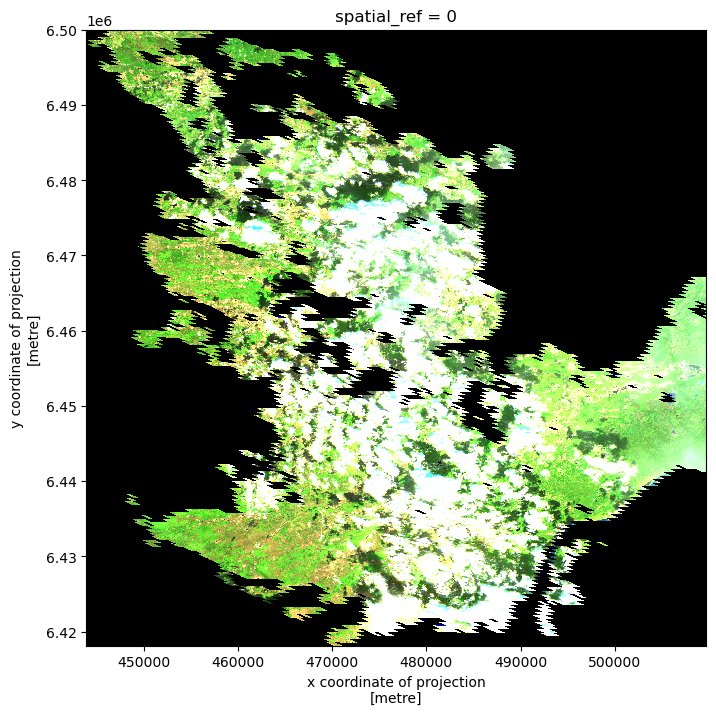

In [20]:
image_false = false_color(image_dir + files[1], granules[1], image_DIRs[1], "jp2", False)

fig, axes = plt.subplots(figsize=(8,8))
# image_false.plot.imshow(ax=axes)
(image_false/2000).clip(0,1).plot.imshow(ax=axes)
fig.savefig(f'images/masked/falsecolor_event_{fire_id}_post_{files[1].split("_")[2]}.png', dpi=300)

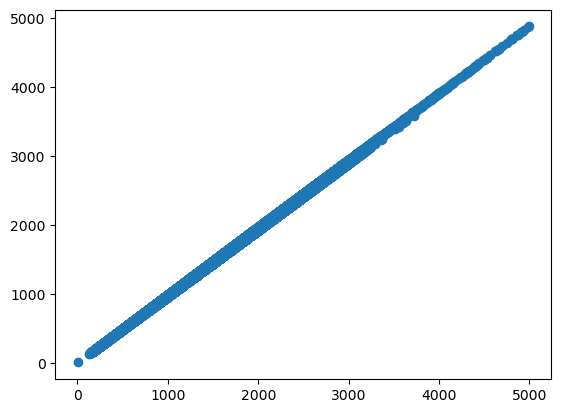

In [27]:
plt.scatter(SR_images[0].sel(band="nir"), Brdf_images[0].sel(band="nir"))
# SR_images[0].sel(band="nir")

In [18]:
nir_0 = np.ma.array(SR_images[0].sel(band="nir"), mask=np.isnan(SR_images[0].sel(band="nir")))
nir_1 = np.ma.array(SR_images[1].sel(band="nir"), mask=np.isnan(SR_images[1].sel(band="nir")))

In [19]:
swir_0 = np.ma.array(SR_images[0].sel(band="swir"), mask=np.isnan(SR_images[0].sel(band="swir")))
swir_1 = np.ma.array(SR_images[1].sel(band="swir"), mask=np.isnan(SR_images[1].sel(band="swir")))

In [20]:
nir_brdf_0 = np.ma.array(Brdf_images[0].sel(band="nir"), mask=np.isnan(Brdf_images[0].sel(band="nir")))
nir_brdf_1 = np.ma.array(Brdf_images[1].sel(band="nir"), mask=np.isnan(Brdf_images[1].sel(band="nir")))

In [21]:
swir_brdf_0 = np.ma.array(Brdf_images[0].sel(band="swir"), mask=np.isnan(Brdf_images[0].sel(band="swir")))
swir_brdf_1 = np.ma.array(Brdf_images[1].sel(band="swir"), mask=np.isnan(Brdf_images[1].sel(band="swir")))

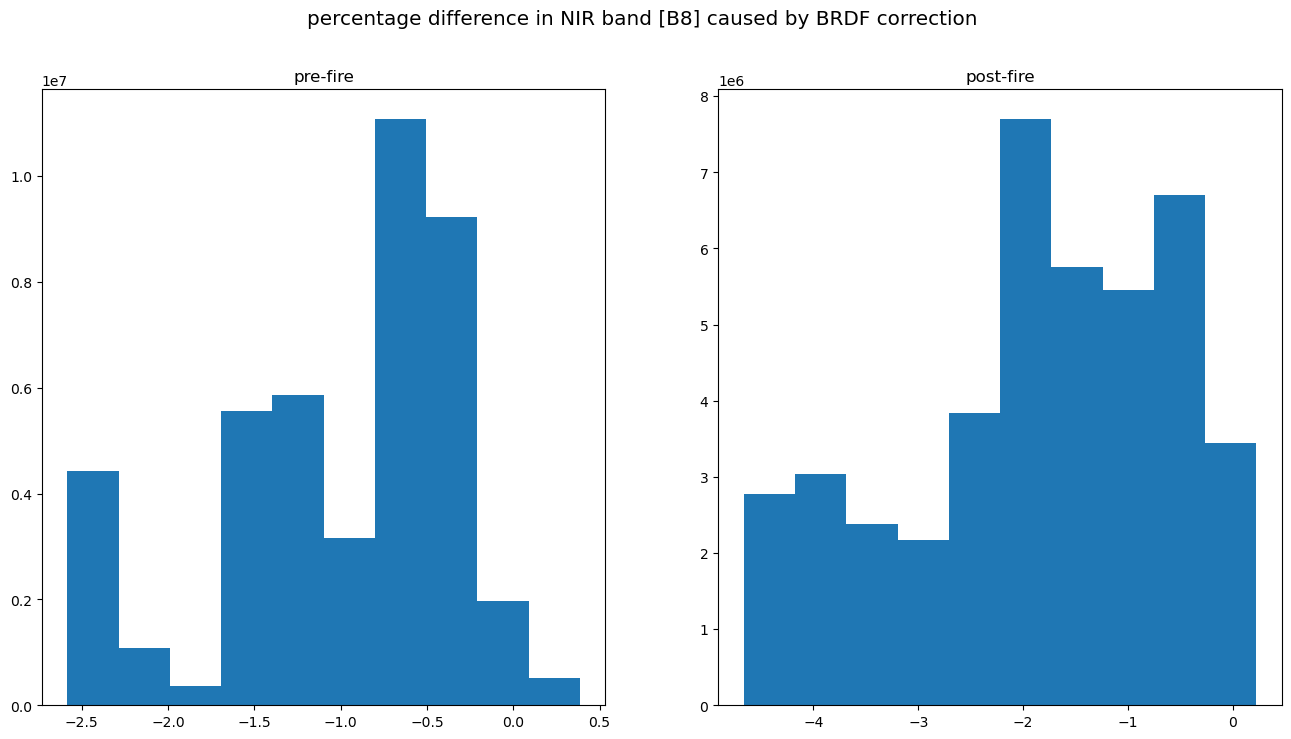

In [22]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("percentage difference in NIR band [B8] caused by BRDF correction", fontsize="x-large")

nir_diff_prefire = ((nir_brdf_0-nir_0)/nir_0)*100
nir_diff_postfire = ((nir_brdf_1-nir_1)/nir_1)*100
axes[0].hist(nir_diff_prefire.ravel())
axes[1].hist(nir_diff_postfire.ravel())

axes[0].set_title("pre-fire")
axes[1].set_title("post-fire")

fig.savefig(f'images/masked/NIR_difference_event_{fire_id}.png', dpi=300)

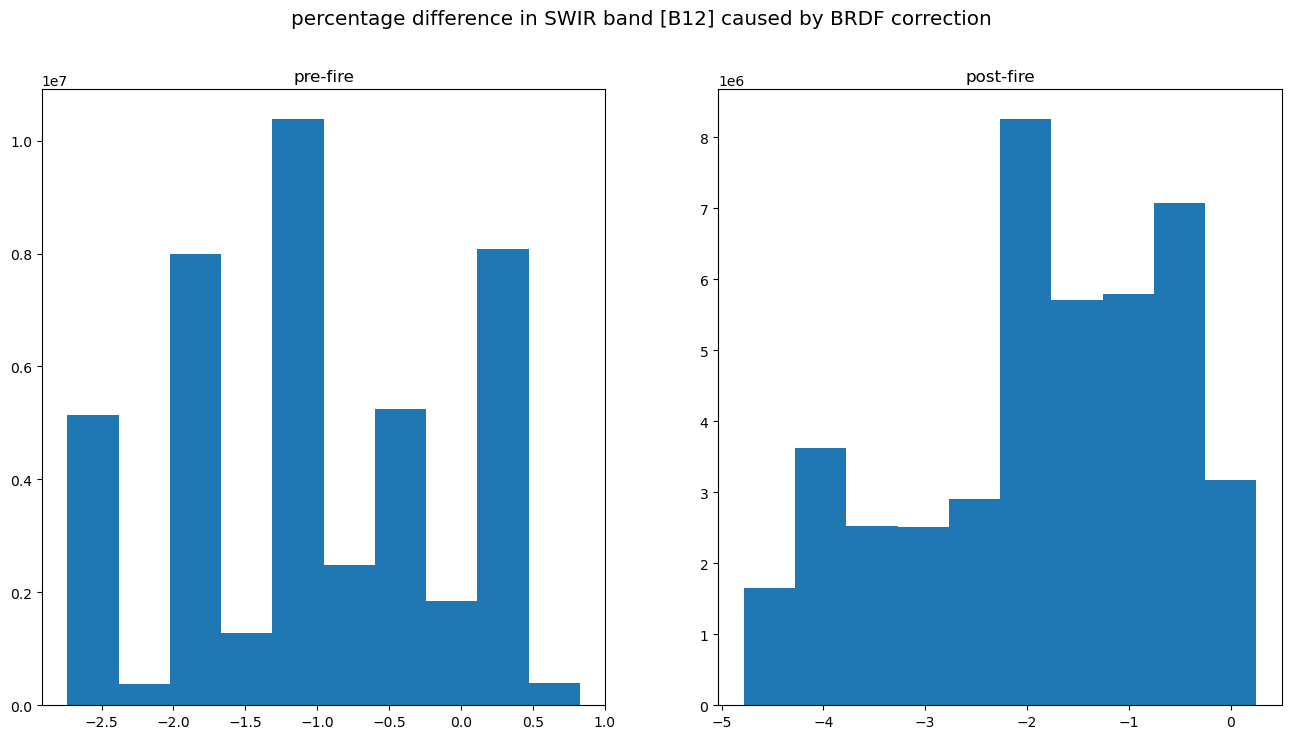

In [23]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("percentage difference in SWIR band [B12] caused by BRDF correction", fontsize="x-large")

swir_diff_prefire = ((swir_brdf_0-swir_0)/swir_0)*100
swir_diff_postfire = ((swir_brdf_1-swir_1)/swir_1)*100
axes[0].hist(swir_diff_prefire.ravel())
axes[1].hist(swir_diff_postfire.ravel())

axes[0].set_title("pre-fire")
axes[1].set_title("post-fire")

fig.savefig(f'images/masked/SWIR_difference_event_{fire_id}.png', dpi=300)

Text(0.5, 1.0, 'post-fire')

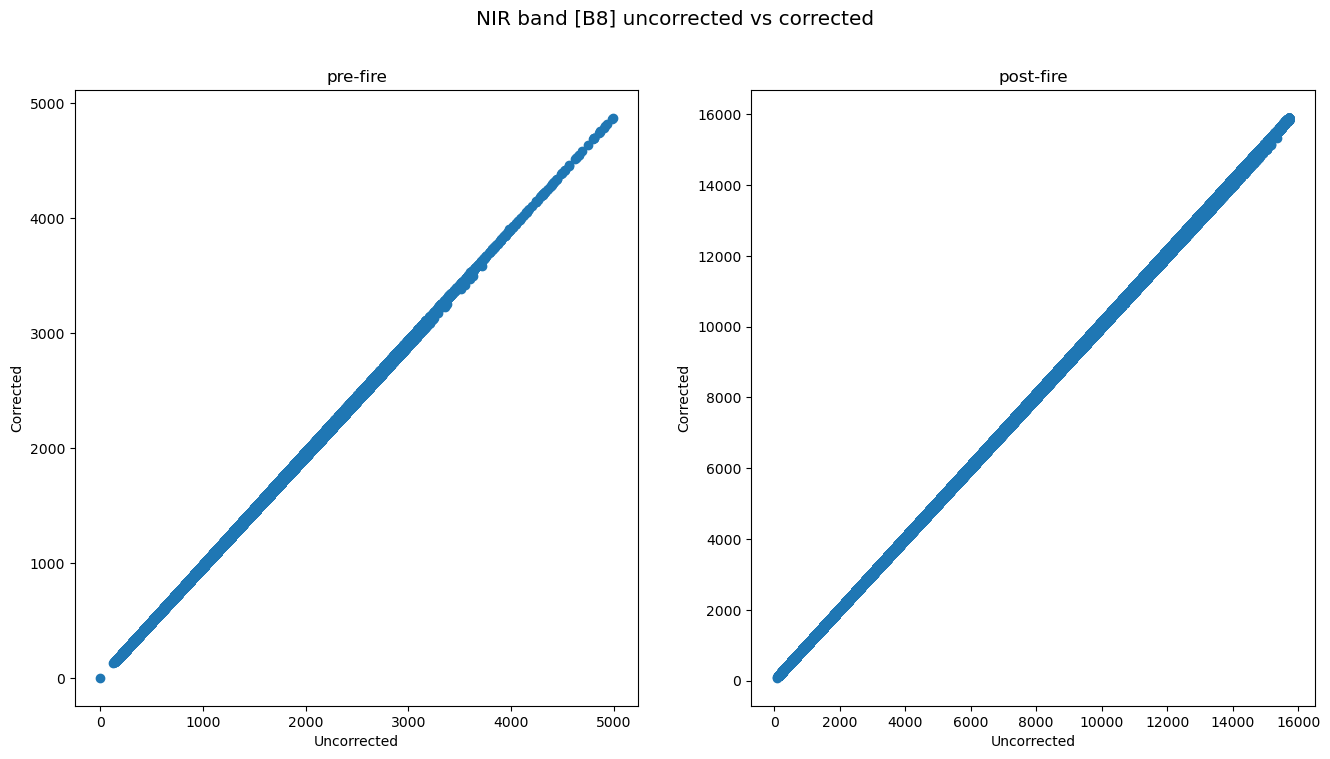

In [33]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("NIR band [B8] uncorrected vs corrected", fontsize="x-large")

axes[0].scatter(nir_0, nir_brdf_0)
axes[1].scatter(nir_1, nir_brdf_1)

for ax in axes.ravel():
    ax.set_xlabel("Uncorrected")
    ax.set_ylabel("Corrected")

axes[0].set_title("pre-fire")
axes[1].set_title("post-fire")

# fig.savefig(f'images/NIR_scatter_event_{fire_id}.png', dpi=300)

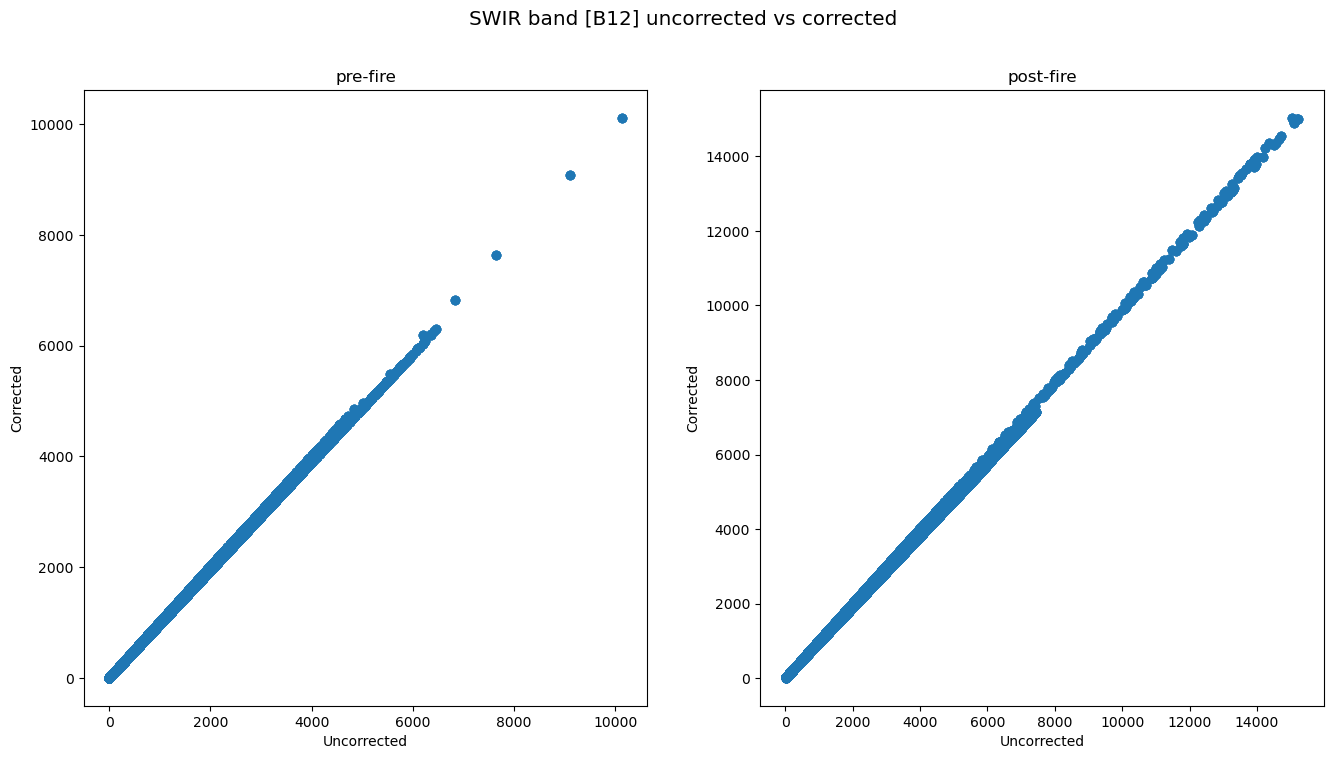

In [24]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("SWIR band [B12] uncorrected vs corrected", fontsize="x-large")


axes[0].scatter(swir_0, swir_brdf_0)
axes[1].scatter(swir_1, swir_brdf_1)

for ax in axes.ravel():
    ax.set_xlabel("Uncorrected")
    ax.set_ylabel("Corrected")

axes[0].set_title("pre-fire")
axes[1].set_title("post-fire")

fig.savefig(f'images/SWIR_scatter_event_{fire_id}.png', dpi=300)

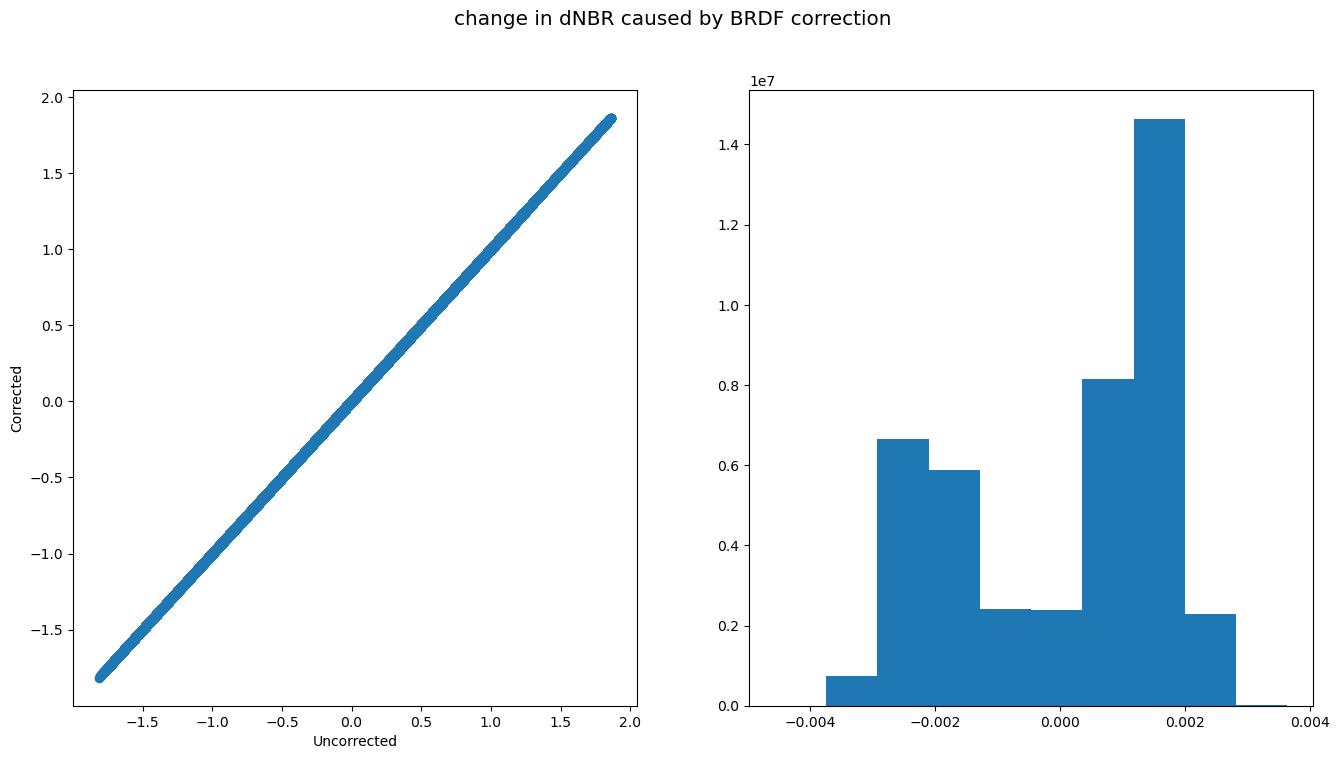

In [24]:
dNBR_post_BRDF = nbr_brdfs["pre_fire"] - nbr_brdfs["post_fire"]
dNBR_post_raw = nbr_raws["pre_fire"] - nbr_raws["post_fire"]


fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("change in dNBR caused by BRDF correction", fontsize="x-large")

dNBR_diff = dNBR_post_BRDF.to_numpy() - dNBR_post_raw.to_numpy()
filtered_diff = dNBR_diff[~is_outlier(dNBR_diff)]

axes[0].scatter(dNBR_post_raw, dNBR_post_BRDF)
axes[1].hist(filtered_diff.ravel())

axes[0].set_xlabel("Uncorrected")
axes[0].set_ylabel("Corrected")

# axes[0].set_title("pre-fire")
# axes[1].set_title("post-fire")

fig.savefig(f'images/masked/dNBR_difference_event_{fire_id}.png', dpi=300)

### Save Tiff files

In [26]:
# save pre and postfire raw and BRDF-corrected NBRs as tiff files
for image_directory, label in zip(file_address, labels):
    f_name_raw = os.path.join(image_directory.split(dir_separator)[0], f'NBR_raw_{label}.tif')
    f_name_brdf = os.path.join(image_directory.split(dir_separator)[0], f'NBR_brdf_{label}.tif')

    nbr_raws[label].rio.to_raster(f_name_raw)
    nbr_brdfs[label].rio.to_raster(f_name_brdf)

In [27]:
# save raw and BRDF-corrected dNBRs as tiff files
f_name_diff = os.path.join(image_directory.split(dir_separator)[0], f'dNBR raw pre-post fire.tif')
dNBR_post_raw.rio.to_raster(f_name_diff)
f_name_diff_brdf = os.path.join(image_directory.split(dir_separator)[0], f'dNBR BRDF pre-post fire.tif')
dNBR_post_BRDF.rio.to_raster(f_name_diff_brdf)

In [28]:
MASK_IMAGES = False

In [29]:
# Save pre and postfire RGB images as tiff files

rgb_images = dict.fromkeys(labels, None)

for file, granule, image_name, label in zip(files, granules, image_DIRs, labels):
    rgb = open_RGB(image_dir + file , f"GRANULE/{granule}/IMG_DATA/R10m", image_name, "jp2", False)
    rgb_images[label] = rgb
    f_name = os.path.join(image_dir.split(dir_separator)[0], f'RGB_{label}.tif')
    rgb_images[label].rio.to_raster(f_name)

In [30]:
# Save pre and postfire false color composite image as tiff

fcc_images = dict.fromkeys(labels, None)

for file, granule, image_name, label in zip(files, granules, image_DIRs, labels):
    rgb = false_color(image_dir + file, granule, image_name, "jp2", False)
    fcc_images[label] = rgb
    f_name = os.path.join(image_dir.split(dir_separator)[0], f'false_color_{label}.tif')
    fcc_images[label].rio.to_raster(f_name)